# Vitamin B dependencies
In this notebook we are looking at vitamin B dependencies and auxotrophies. Is growth increasing when adding vitamins to the medium? Which models depend on vitamins? If we have experimental data available, can we incorporate auxotrophies in our models based on in vitro/vivo results?

# Imports & Load Individual Models

In [1]:
# basic
import os

# see functions.py for a collection of self-written functions for analysing and visualising my models
from functions import *

# cobra & micom
from cobra.io import read_sbml_model, write_sbml_model
from micom import Community
from cobra import Metabolite, Reaction

# plots
import matplotlib.pyplot as plt

In [2]:
# Load SBML Models
models_path = "../Models/12_gap_filled/"
models = {}
for model_name in (f for f in os.listdir(models_path) if f.endswith(".xml")):
    model = read_sbml_model(f"{models_path}/{model_name}")
    model.solver = "cplex"
    name = str(model_name[:3])
    models[name] = model

models = {key: models[key] for key in sorted(models.keys())}  # sorts the dictionary alphabetically
AA1, AA2, AA3, AA4, AA5, AA6, AA7 = [models[f"AA{i}"] for i in range(1, 8)]

Restricted license - for non-production use only - expires 2026-11-23


In [3]:
AA2_btn = read_sbml_model("../Models/13_vitamin/AA2_vitamin.xml")
AA2_btn.solver = "cplex"

In [4]:
AA3_btn_pan = read_sbml_model("../Models/13_vitamin/AA3_vitamin.xml")
AA3_btn_pan.solver = "cplex"

In [33]:
# Load SBML Models
# these models are used later on to add exchange reactions for vitamins to check for possible auxotrophies
models_path = "../Models/12_gap_filled/"
models_vit = {}
for model_name in (f for f in os.listdir(models_path) if f.endswith(".xml")):
    model = read_sbml_model(f"{models_path}/{model_name}")
    model.solver = "cplex"
    name = str(model_name[:3]+"_vit")
    models_vit[name] = model

models_vit = {key: models_vit[key] for key in sorted(models_vit.keys())}  # sorts the dictionary alphabetically
AA1_v, AA2_v, AA3_v, AA4_v, AA5_v, AA6_v, AA7_v = [models_vit[f"AA{i}_vit"] for i in range(1, 8)]

# Functions

In [ ]:
def add_rxn(model, rxn_id, rxn_name, bounds, met_dict):
    rxn = Reaction(rxn_id)
    rxn.name = rxn_name
    rxn.lower_bound, rxn.upper_bound = bounds

    # get mets from met_dict and check if they are already in model or a variable from a new metabolite
    resolved_metabolites = {}
    for met, coeff in met_dict.items():
        if isinstance(met, str):
            resolved_met = model.metabolites.get_by_id(met)
        else:
            resolved_met = met
        resolved_metabolites[resolved_met] = coeff

    rxn.add_metabolites(resolved_metabolites)
    model.add_reactions([rxn])


def add_met_to_rxn(model, rxn_id, met_id, stoichiometry):
    # check if met_id and rxn_id exist in model
    if met_id in model.metabolites and rxn_id in model.reactions:
        # get rxn and the mets that are already participating
        rxn = model.reactions.get_by_id(rxn_id)
        rxn_mets = [met.id for met in rxn.metabolites]
        # if met is not already in rxn, add it
        if met_id not in rxn_mets:
            rxn.add_metabolites({model.metabolites.get_by_id(met_id): stoichiometry})
        else:
            print("Metabolite is already in reaction")
    else:
        print("Check if Metabolite and Reaction exist")


In [3]:
def get_V8_medium(base_medium, vitamin_list):
    vitamin_med_V8 = base_medium.copy()

    # Make new rows
    new_rows = pd.DataFrame({
        "reaction": vitamin_list,
        "bound": [10] * len(vitamin_list)
    })

    # Concatenate
    vitamin_med_V8 = pd.concat([vitamin_med_V8, new_rows], ignore_index=True)
    return vitamin_med_V8

In [4]:
# Compare V0 and V8
def vitamin_growth_plots(models, maize_medium, vitamin_list, save_path=None):
    V8_medium = get_V8_medium(maize_medium, vitamin_list)

    # check if models is dict or rather if we have a singular model (which is a community model)
    if not isinstance(models, dict) and not hasattr(models, "__len__"):
        models = {"Community": models}

    results = []
    for model in models.values():
        growth_V0 = test_medium(model, maize_medium)
        growth_V8 = test_medium(model, V8_medium)

        if len(models) == 1 and isinstance(growth_V0, pd.Series): # we have only the community model and wanna see growth of the individual models within the community
            model_ids = growth_V0.index.tolist()
            growth_V0 = growth_V0.values.tolist()
            growth_V8 = growth_V8.values.tolist()
            break

        if isinstance(growth_V0, pd.Series): # make the average for the community model to plot only one value
            growth_V0 = sum(growth_V0)/len(growth_V0)
            growth_V8 = sum(growth_V8)/len(growth_V8)

        # if none of the above if statements are true then we have a normal case with only individual models
        results.append((model.id, growth_V0, growth_V8))

    # Convert to arrays
    if results: # if list is not empty (in case we have only a community model, these are already assigned)
        model_ids = [r[0] for r in results]
        growth_V0 = [r[1] for r in results]
        growth_V8 = [r[2] for r in results]


    # Set up positions
    x = np.arange(len(model_ids))
    width = 0.43  # width of bars

    sns.set_theme(style="whitegrid", rc={"figure.figsize": (10, 5)})  # white background + light gray grid

    fig, ax = plt.subplots()

    # Two bar groups
    bars1 = ax.bar(x - width/2, growth_V0, width, label="V0 (No B-Vitamins)", color="lemonchiffon")
    bars2 = ax.bar(x + width/2, growth_V8, width, label="V8 (Full B-Vitamin Mix)", color="cornflowerblue")

    # Add labels and formatting
    ax.set_ylabel("growth rate\n[mmol/(gDW h)]")
    ax.set_xlabel("Strains")
    if len(models) == 1:
        ax.set_xlabel("Strains within the Community Model")
    ax.set_title("Growth comparison with and without all B vitamins")
    ax.set_xticks(x)
    strain_codes = ["Sma", "Bpi", "Cpu", "Elu", "Cin", "Hro", "Ppu"] # this is the same if we use only individual models or only the community model and then look at the strains within
    if len(model_ids) == 8:
        strain_codes = ["Sma", "Bpi", "Cpu", "Elu", "Cin", "Hro", "Ppu", "C7"]
    ax.set_xticklabels(strain_codes, rotation=45)
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

    # annotate bars with values
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f"{height:.2f}",
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha="center", va="bottom", fontsize=8)

    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path)

    plt.show()

In [5]:
# Plot V1 & V7 Experiments
def plot_v1_v7_growth(model, growth_val_without, growth_val_v8, growth_vals_vx, vitamins, mode, save_path=None):

    # Combine all values
    all_growth = [growth_val_without, growth_val_v8] + growth_vals_vx

    # Numeric positions for bars
    x = np.arange(len(all_growth))

    # Create barplot
    plt.figure(figsize=(10, 6))
    """ This is coloring like in Krumbach
    if mode == "V1":
        bars = plt.bar(x, all_growth, color=["lemonchiffon"])
    elif mode =="V7":
        bars = plt.bar(x, all_growth, color=["cornflowerblue"])
        vitamins = [f"V7 (-{vit})" for vit in vitamins]
    else:
        raise ValueError("mode must be either 'V1' or 'V7'")
    """

    # Choose bar colors
    if mode == "V1":
        # pastel color for V1 bars
        pastel_color = "mistyrose"
    elif mode =="V7":
        # pastel color for V7 bars
        pastel_color = "lightblue"
        # update labels for vitamins
        vitamins = [f"V7 (-{vit})" for vit in vitamins]
    else:
        raise ValueError("mode must be either 'V1' or 'V7'")

    # First two bars fixed colors, rest get pastel
    colors = ["lemonchiffon", "cornflowerblue"] + [pastel_color] * len(vitamins)
    bars = plt.bar(x, all_growth, color=colors)

    # Labeling
    plt.ylabel("growth rate\n[mmol/(gDW h)]")
    plt.xlabel("Added B Vitamins")
    plt.title(f"{mode} Experiments: Growth under different media conditions for {model.id}")

    # Add values on top of bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.2f}",
                 ha="center", va="bottom", fontsize=8)

    # Set x-axis labels properly under each bar
    all_labels = ["V0", "V8"] + vitamins
    plt.xticks(x, all_labels, rotation=45, ha='right')
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path)

    plt.show()


# V1 Experiments
def get_v1_growth(model, mode, list_carbon_source, list_of_vitamins, extra_vitamin_names=None, save_path=None):
    # add single carbon source to minimal media
    carbon_sources = pd.DataFrame({"reaction": list_carbon_source, "bound": [10]*len(list_carbon_source)})
    basic_med = pd.concat([m9, carbon_sources], ignore_index=True)

    # Full vitamin medium (V8)
    med_V8 = get_V8_medium(basic_med, list_of_vitamins)

    with model:
        growth_val_without = test_medium(model, basic_med) # V0
        growth_val_v8 = test_medium(model, med_V8) # V8

    growth_vals_v1 = []
    vitamin_names = []
    for vitamin in list_of_vitamins: # go through list of EX reactions
        vitamin_name = list(model.reactions.get_by_id(vitamin).metabolites.keys())[0].name if vitamin in model.reactions else vitamin
        vitamin_names.append(vitamin_name)

        vitamin_med = basic_med.copy()

        new_row = pd.DataFrame([{"reaction": vitamin, "bound": 10}])
        vitamin_med = pd.concat([vitamin_med, new_row], ignore_index=True)

        with model:
            growth_val_v1 = test_medium(model, vitamin_med)
            growth_vals_v1.append(growth_val_v1)

    if extra_vitamin_names is not None:
        plot_v1_v7_growth(model, growth_val_without, growth_val_v8, growth_vals_v1, extra_vitamin_names, mode, save_path)
    else:
        plot_v1_v7_growth(model, growth_val_without, growth_val_v8, growth_vals_v1, vitamin_names, mode, save_path)

In [6]:
# V7 Experiments
def get_v7_growth(model, mode, list_carbon_source, list_of_vitamins, extra_vitamin_names=None, save_path=None):
    # Add single carbon source to minimal media
    carbon_sources = pd.DataFrame({"reaction": list_carbon_source, "bound": [10]*len(list_carbon_source)})
    basic_med = pd.concat([m9, carbon_sources], ignore_index=True)

    # Full vitamin medium (V8)
    med_V8 = get_V8_medium(basic_med, list_of_vitamins)

    with model:
        growth_val_without = test_medium(model, basic_med)  # basic medium
        growth_val_v8 = test_medium(model, med_V8)          # all vitamins

    growth_vals_drop = []
    dropped_vitamin_names = []

    # Drop one vitamin at a time
    for vitamin in list_of_vitamins:
        # Medium with all vitamins except the current one
        vitamin_med = med_V8[~med_V8['reaction'].isin([vitamin])].copy()

        # Get human-readable vitamin name
        vitamin_name = list(model.reactions.get_by_id(vitamin).metabolites.keys())[0].name \
                       if vitamin in model.reactions else vitamin
        dropped_vitamin_names.append(vitamin_name)

        with model:
            growth_val = test_medium(model, vitamin_med)
            growth_vals_drop.append(growth_val)

    # Plot
    if extra_vitamin_names is not None:
        plot_v1_v7_growth(model, growth_val_without, growth_val_v8, growth_vals_drop, extra_vitamin_names, mode, save_path)
    else:
        plot_v1_v7_growth(model, growth_val_without, growth_val_v8, growth_vals_drop, dropped_vitamin_names, mode, save_path)


# Medium

In [5]:
m9 = pd.read_csv("../Datasets/Medium/medium_M9.csv", sep=";")
m9_rxn = list(m9["reaction"])


medium_combined_naveed = pd.read_csv("../Datasets/Medium/medium_combined_Naveed_M9.csv", sep=";", quotechar='"')
medium_combined_krumbach = pd.read_csv("../Datasets/Medium/medium_combined_Krumbach_M9.csv", sep=";", quotechar='"')


ecoplate = pd.read_csv("../Datasets/Medium/medium_ecoplate_carbon.csv", sep=";", quotechar='"')
ecoplate_rxns = [safe_parse(x) for x in ecoplate["reaction"]]
ecoplate_short = pd.read_csv("../Datasets/Medium/medium_ecoplate_carbon_shortened.csv", sep=";", quotechar='"')
ecoplate_rxns_short = [safe_parse(x) for x in ecoplate_short["reaction"]]

# Fill Biotin Synthase Pathway for AA2
Hu and Cronan (2020): α-proteobacteria synthesize biotin precursor pimeloyl-ACP using BioZ 3-ketoacyl-ACP synthase and lysine catabolism. https://doi.org/10.1038/s41467-020-19251-5

The pathway they introduce is used by Alphaproteobacteria, only Brucella (Bpi, AA2) fits into this category out of my seven bacteria. \
Another pathway for biotin synthesis that was already studied in E.coli is described here: https://doi.org/10.1038/nchembio.420

What needs to be added?

(1) Metabolites
- malACP_c (BIGG) with Malonyl-[acyl-carrier protein], C387H604N96O145P1S3 and -1
- opACP_c (NEW) with 3-Keto-pimeloyl-[acyl-carrier protein], C391H610N96O146PS3 and -1 \
--> 3-Keto == 3-Oxo
- hpACP_c (NEW) with 3-Hydroxy-pimeloyl-[acyl-carrier protein], C391H612N96O146PS3 and -1
- epACP_c (NEW) with Enoyl-pimeloyl-[acyl-carrier protein], C391H610N96O145PS3 and -1
- pimACP_c (BIGG) with Pimeloyl-[acyl-carrier protein], C391H612N96O145PS3 and -1 (formula doesnt match)

(2) Reactions
- MCOATA (BIGG): ACP_c + malcoa_c --> coa_c + malACP_c
- OPACPS (NEW): glutcoa_c + malACP_c + h_c --> co2_c + coa_c + opACP_c
- HPACPS (NEW): opACP_c + nadph_c + h_c --> nadp_c + hpACP_c
- EPACPS (NEW): hpACP_c --> epACP_c + h2o_c
- PIMACPS (NEW): epACP_c + nadh_c + h_c --> pimACP_c + nad_c
- AOXSr2 (BIGG, modified): ala__L_c + pimACP_c + h_c ⇌ 8aonn_c + ACP_c + co2_c

In [19]:
malACP = Metabolite(
    'malACP_c',
    formula='C387H604N96O145P1S3',
    name='Malonyl-[acyl-carrier protein]',
    compartment='C_c'
)

opACP = Metabolite(
    'opACP_c',
    formula='C391H610N96O146PS3',
    name='3-Keto-pimeloyl-[acyl-carrier protein]',
    compartment='C_c'
)

hpACP = Metabolite(
    'hpACP_c',
    formula='C391H612N96O146PS3',
    name='3-Hydroxy-pimeloyl-[acyl-carrier protein]',
    compartment='C_c'
)

epACP = Metabolite(
    'epACP_c',
    formula='C391H610N96O145PS3',
    name='Enoyl-pimeloyl-[acyl-carrier protein]',
    compartment='C_c'
)

pimACP = Metabolite(
    'pimACP_c',
    formula='C391H612N96O145PS3',
    name='Pimeloyl-[acyl-carrier protein]',
    compartment='C_c'
)

In [21]:
add_rxn(AA2_btn, "MCOATA", "Malonyl-CoA-ACP transacylase", (0.0, 1000.0),
        {'ACP_c': -1, 'malcoa_c': -1, 'coa_c': 1, malACP: 1})

In [22]:
add_rxn(AA2_btn, "OPACPS", "3-Keto-pimeloyl-ACP Synthase", (0.0, 1000.0),
        {'glutcoa_c': -1, 'malACP_c': -1, 'h_c': -1, 'co2_c': 1, 'coa_c': 1, opACP: 1})

add_rxn(AA2_btn, "HPACPS", "3-Hydroxy-pimeloyl-ACP Synthase", (0.0, 1000.0),
        {'opACP_c': -1, 'nadph_c': -1, 'h_c': -1, 'nadp_c': 1, hpACP: 1})

add_rxn(AA2_btn, "EPACPS", "Enoyl-pimeloyl-ACP Synthase", (0.0, 1000.0),
        {'hpACP_c': -1, 'h2o_c': 1, epACP: 1})

add_rxn(AA2_btn, "PIMACPS", "Pimeloyl-ACP Synthase", (0.0, 1000.0),
        {'epACP_c': -1, 'nadh_c': -1, 'h_c': -1, 'nad_c': 1, pimACP: 1})

add_rxn(AA2_btn, "AOXSr2", "8-amino-7-oxononanoate synthase", (0.0, 1000.0),
        {'ala__L_c': -1, 'pimACP_c': -1, 'h_c': -1, '8aonn_c': 1, 'ACP_c': 1, "co2_c": 1})

In [116]:
add_met_to_rxn(AA2, "Growth", "btn_c", -0.000223)

In [88]:
add_met_to_rxn(AA2_v, "Growth", "btn_c", -0.000223)

In [84]:
met = AA2.metabolites.get_by_id("btn_c")
rxn_id = "Growth"
AA2.reactions.get_by_id(rxn_id).add_metabolites({met: 0}, combine=False)

In [8]:
new_row = {"reaction": "EX_thm_e", "bound": 10.0}
medium_combined_krumbach_thm = pd.concat([medium_combined_krumbach, pd.DataFrame([new_row])], ignore_index=True)

In [63]:
fluxies = get_pfba_fluxes(AA2, medium_combined_krumbach_thm)

# Add Auxotrophies based on Krumbach
Bpi (AA2) - B1 and B7 \
Cpu (AA3) - B1, B2, B3, B5, B6, B7, B9 (all excpect B12) \
Cin (AA5) did not grow in Krumbach (it probably has auxotrophies but they couldnt be identified)

In [14]:
# B1 is already in biomass as thmpp_c
add_met_to_rxn(AA2_btn, "Growth", "btn_c", -0.000223) # B7; stoichiometry is based on already existing vitamins in biomass like thmpp

In [23]:
write_sbml_model(AA2_btn, "../Models/13_vitamin/AA2_vitamin.xml")

In [132]:
# B1 is already in biomass as thmpp
# B2 is already in biomass as ribflv_c
# B3 is already in biomass as nad_c (nad_c can be converted direcly into ncam_c)
add_met_to_rxn(AA3, "Growth", "pnto__R_c", -0.000223) # B5
# B6 is already in biomass as pydx5p_c
add_met_to_rxn(AA3, "Growth", "btn_c", -0.000223) # B7
# B9 is already in biomass as 10fthf_c (10fthf_c and thf and 5mthf can be converted into each other)

In [136]:
write_sbml_model(AA3, "../Models/13_vitamin/AA3_vitamin.xml")

# Create Community
The below csv file to get taxonomy includes absolute paths to the individual models, i.e. the community_model_gap_filled.csv file has to be changed depending on the file paths of the current user.

In [8]:
taxonomy = pd.read_csv("../Datasets/taxonomy_community_micom.csv", sep=";")
syncom = Community(taxonomy.iloc[:, :-1], name="synthetic seven member bacterial community", id="C7", solver="cplex")

# change the lower bound of Exchange reactions (EX between bacteria and medium)
for rxn in syncom.reactions.query("^EX_"):
    rxn.lower_bound = -1000

Output()

In [9]:
all_models = {**models, 'Community': syncom}

# B Vitamins in Our Models & Full Vitamin Medium
I already checked the B vitamins in my 04_Simulations ipynb; AA1, AA5 are missing B12 and AA7 is missing B7 in the model

B1 - Thiamine (C12H17N4OS+) \
BIGG: thm (thiamine), thmmp (Thiamin monophosphate), thmpp (Thiamin diphosphate, active version in body)

B2 - Riboflavin (C17H20N4O6) \
BIGG: ribflv

B3 - Niacin (nicotinic acid)/Niacinamide/Nicotinamide riboside \
--> can be converted into NAD \
BIGG: ncam (Nicotinaminde), nac (Nicotinate), rnam (Ribosylnicotinamide)

B5 - Pantothenic acid (C9H17NO5) \
BIGG: pnto__R (R-pantothenate)

B6 - Pyridoxine/Pyridoxal/Pyridoxamine \
BIGG: pydxn/pydx/pydam

B7 - Biotin (C10H16N2O3S) \
BIGG: btn (biotin)

B9 - Folate (C19H19N7O6) \
BIGG: fol (folate), 5mthf (5-Methyltetrahydrofolate, active form)

B12 - Cobalamin (C63H88CoN14O14P) \
BIGG: b12 (vitamin b12), C06453 (methylcobalamin), adocbl (adenosylcobalamin), adocbi (Adenosyl cobinamide)

In [10]:
Bvitamins = {
    "B1": ["thm", "thmmp", "thmpp"],
    "B2": ["ribflv"],
    "B3": ["ncam", "nicnt", "nac", "rnam"],
    "B5": ["pnto__R"],
    "B6": ["pydam", "pydxn", "pydx"],
    "B7": ["btn"],
    "B9": ["fol", "5mthf"],
    "B12": ["b12", "adocbl", "C06453", "adocbi"]
}

In [11]:
EX_V8 = ["EX_thm_e", "EX_ribflv_e", "EX_nac_e", "EX_rnam_e", "EX_pnto__R_e", "EX_pydxn_e", "EX_btn_e", "EX_fol_e"]
EX_V8_names = ["Thiamin", "Riboflavin", "Niacin", "Ribosylnicotinamide", "Pantothenic acid", "Pyridoxine", "Biotin", "Folate"]
# nac and rnam both B3

carbon sources that were provided as medium in Krumbach

In [12]:
medium_for_vitaminTesting = pd.read_csv("../Datasets/Medium/Carbon_M9_forVitaminTesting.csv", sep=";", quotechar='"')
# 20 diff carbon sources and M9

# V8 - Full Vitamin Mix
see Krumbach, Fig 5a

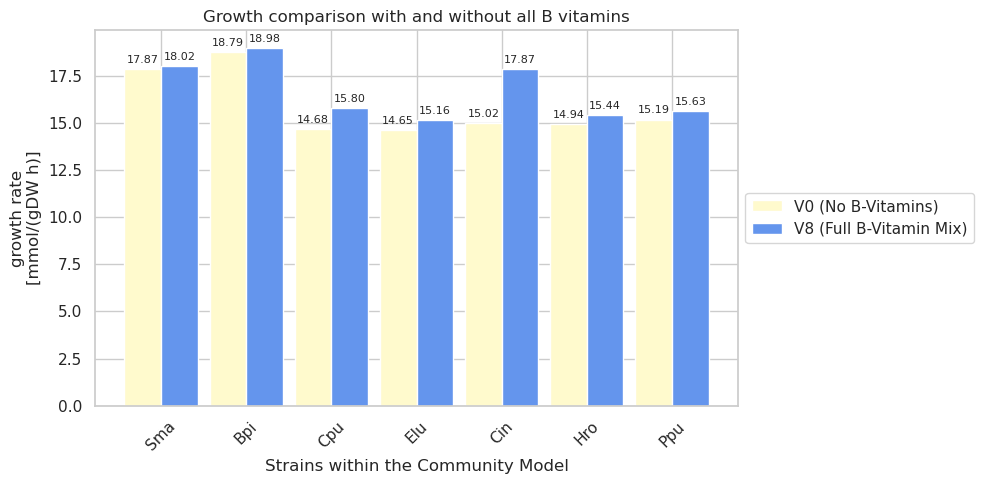

In [13]:
vitamin_growth_plots(syncom, medium_combined_krumbach, EX_V8) # Community, Krumbach Medium

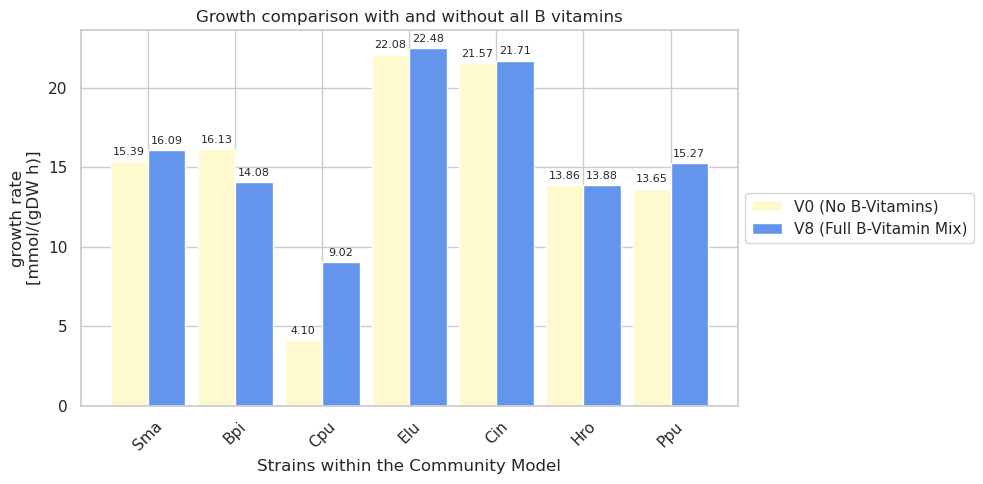

In [14]:
vitamin_growth_plots(syncom, medium_for_vitaminTesting, EX_V8) # Community model, Meidum for Vitamin testing

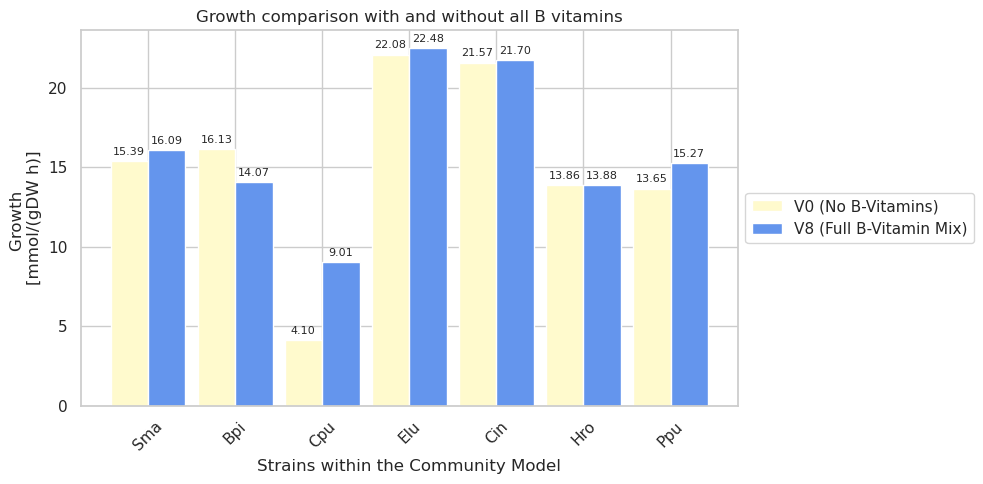

In [59]:
EX_V1 = ["EX_thm_e", "EX_pydxn_e"]
vitamin_growth_plots(syncom, medium_for_vitaminTesting, EX_V1)
# with the function for V8 Growth, I can also test single or only a few vitamins for the whole Syncom, just the plot labels dont fit

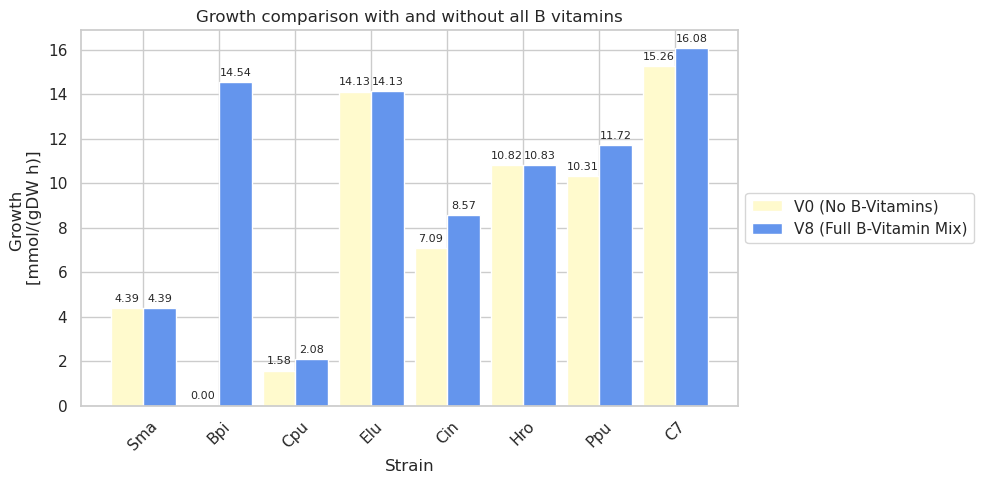

In [54]:
vitamin_growth_plots(all_models, medium_for_vitaminTesting, EX_V8)
# community is averaged

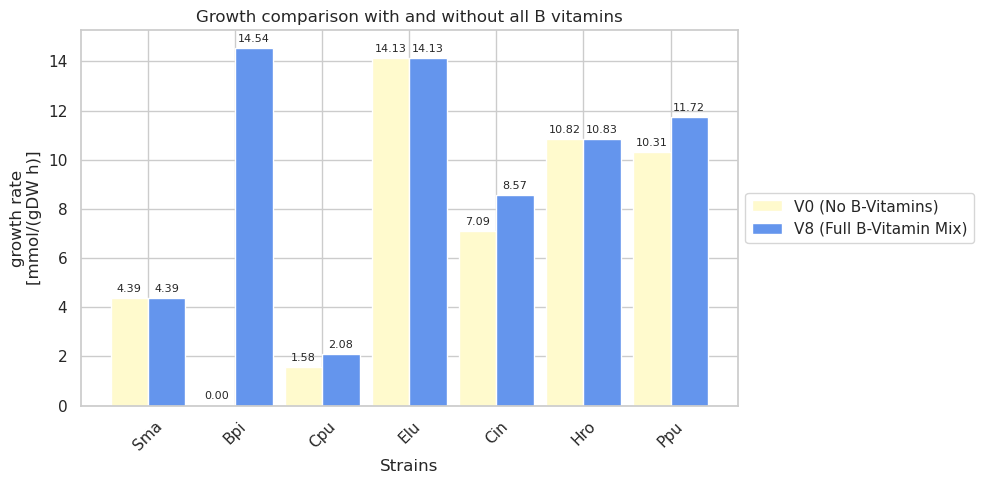

In [15]:
vitamin_growth_plots(models, medium_for_vitaminTesting, EX_V8, "../Figures/MA_Results/VitaminB_all8_Ind.svg")
## THIS IS THE FIGURE THAT IS AS CLOSE AS POSSIBLE TO THE KRUMBACH FIGURE

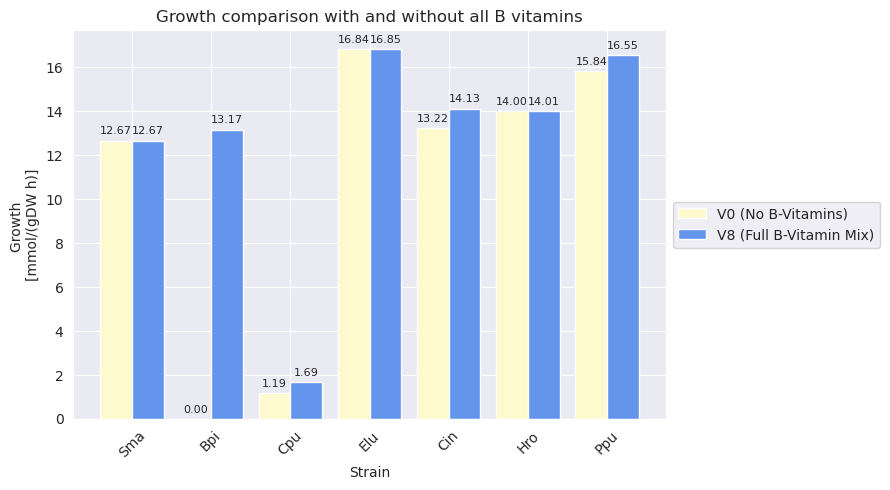

In [45]:
vitamin_growth_plots(models, medium_combined_naveed, EX_V8)

# V1 & V7 - adding one or removing one vitamin
see Krumbach, Figure 6a and 6b

In [46]:
# adding one Vitamin at a time (on Krumbach Medium)
for model in models.values():
    print(model.id)
    for vitamin in EX_V8:
        vitamin_med = medium_combined_krumbach.copy()

        new_row = pd.DataFrame([{"reaction": vitamin, "bound": 10}])
        vitamin_med = pd.concat([vitamin_med, new_row], ignore_index=True)

        with model:
            growth_val = test_medium(model, vitamin_med)
            print(vitamin, growth_val)

    growth_val = test_medium(model, medium_combined_krumbach)
    print("V0", growth_val)

AA1
EX_thm_e 10.684004015899333
EX_ribflv_e 10.684004015899259
EX_nac_e 10.684004015899259
EX_rnam_e 10.684004015899259
EX_pnto__R_e 10.684004015899259
EX_pydxn_e 10.684004015899259
EX_btn_e 10.684004015899259
EX_fol_e 10.684004015899259
V0 10.684004015899259
AA2
EX_thm_e 15.403172919962325
EX_ribflv_e 0.0
EX_nac_e 0.0
EX_rnam_e 0.0
EX_pnto__R_e 0.0
EX_pydxn_e 0.0
EX_btn_e 0.0
EX_fol_e 0.0
V0 0.0
AA3
EX_thm_e 1.9585387730515866
EX_ribflv_e 1.9584272055034517
EX_nac_e 1.9584272055034397
EX_rnam_e 1.958427205503451
EX_pnto__R_e 1.958427205503448
EX_pydxn_e 2.490236623201395
EX_btn_e 1.9584272055034497
EX_fol_e 1.9588623908368592
V0 1.9584272055034555
AA4
EX_thm_e 16.736237910570956
EX_ribflv_e 16.735081796546638
EX_nac_e 16.736378025802047
EX_rnam_e 16.740844352865036
EX_pnto__R_e 16.73540953352886
EX_pydxn_e 16.735081796546574
EX_btn_e 16.735081796546584
EX_fol_e 16.735081796546588
V0 16.735081796546584
AA5
EX_thm_e 12.547903955941692
EX_ribflv_e 12.546695393311582
EX_nac_e 12.546695393

In [16]:
ala = ["EX_ala__L_e","EX_ala__D_e","EX_ala_B_e"]

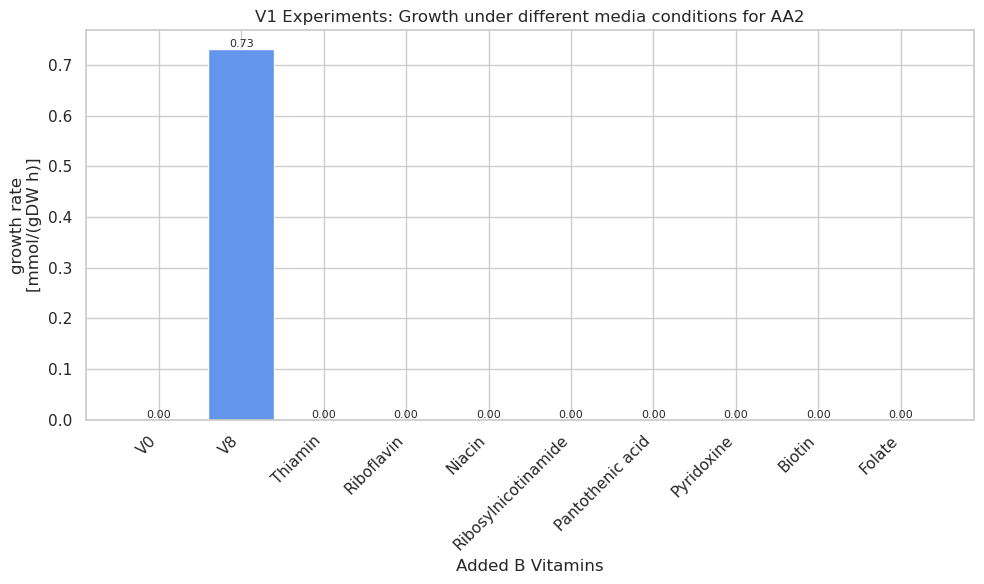

In [90]:
get_v1_growth(AA2_v, "V1", ala, EX_V8, EX_V8_names)

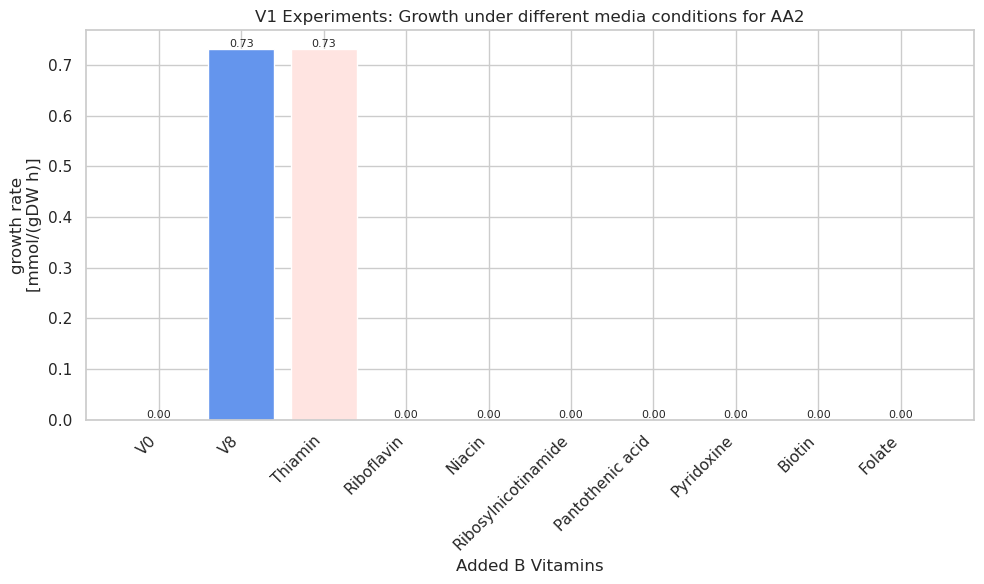

In [20]:
# V1 for Bbi with Alanine as carbon source (+ M9)
ala = ["EX_ala__L_e","EX_ala__D_e","EX_ala_B_e"]
get_v1_growth(AA2, "V1", ala, EX_V8, EX_V8_names, save_path="../Figures/MA_Results/VitaminB_V1_Bpi.svg")

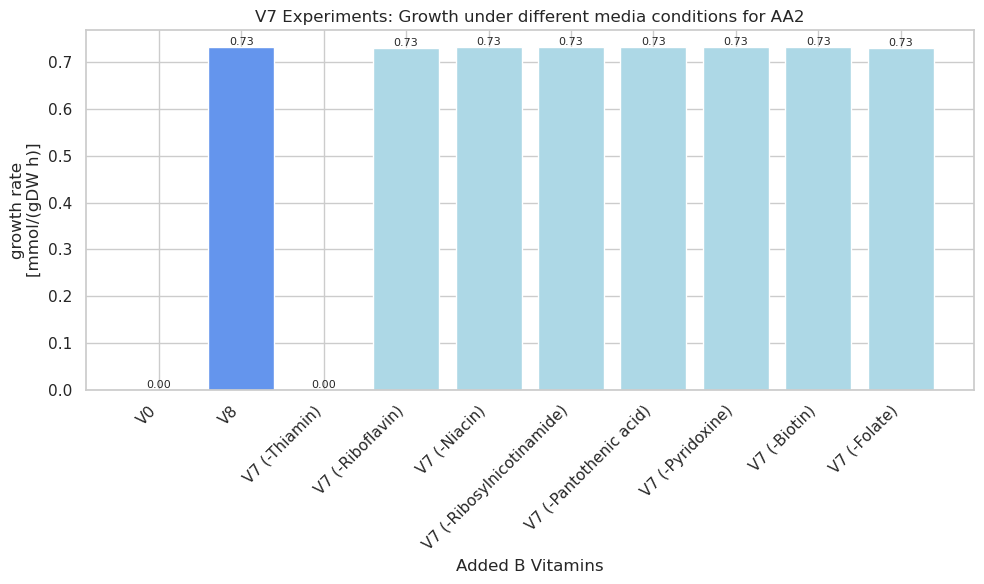

In [21]:
get_v7_growth(AA2, "V7", ala, EX_V8, EX_V8_names, save_path="../Figures/MA_Results/VitaminB_V7_Bpi.svg")

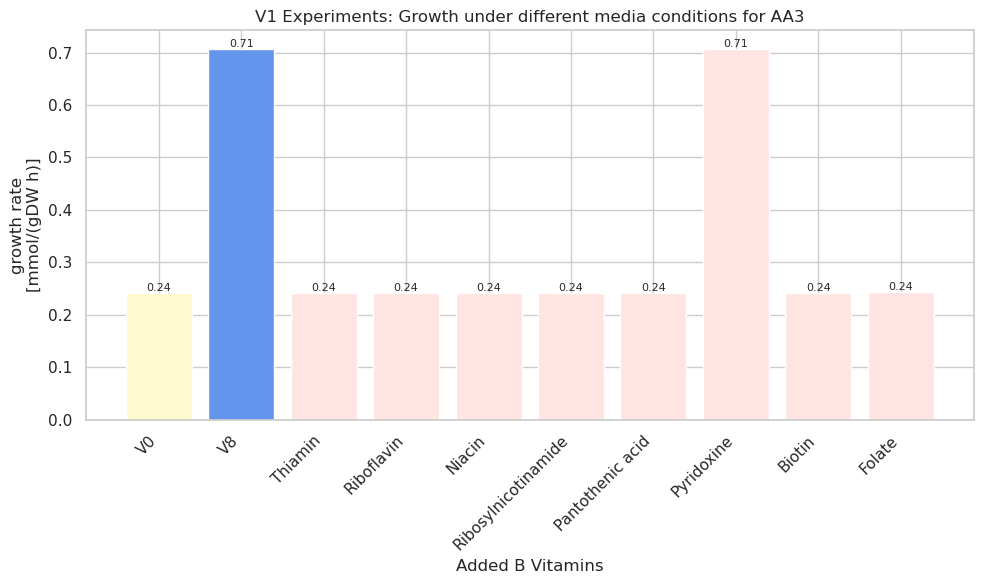

In [22]:
# V1 for Cpu with Glucose as carbon source (+ M9)
glu = ["EX_glc__D_e"]
get_v1_growth(AA3, "V1", glu, EX_V8, EX_V8_names)

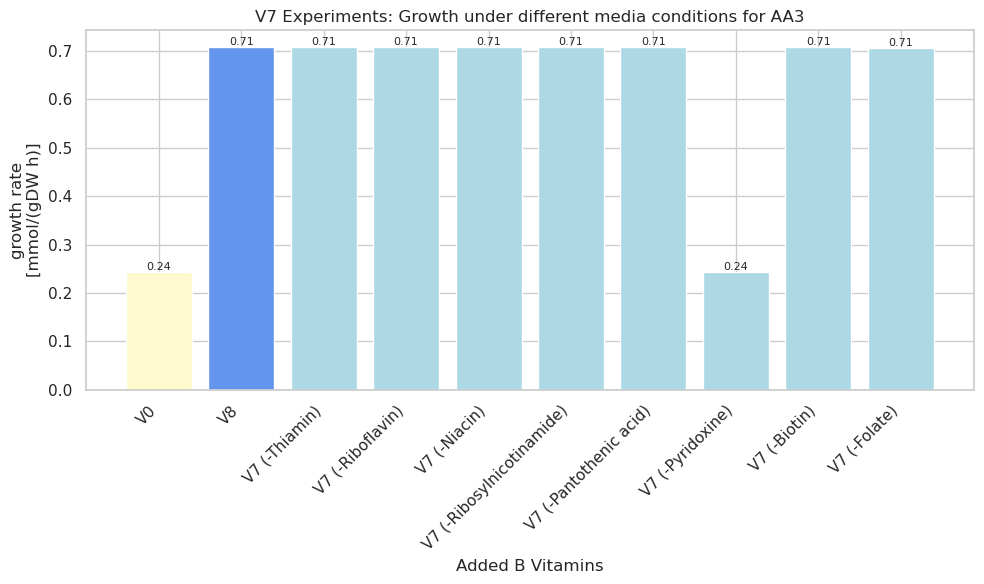

In [23]:
get_v7_growth(AA3, "V7", glu, EX_V8, EX_V8_names)

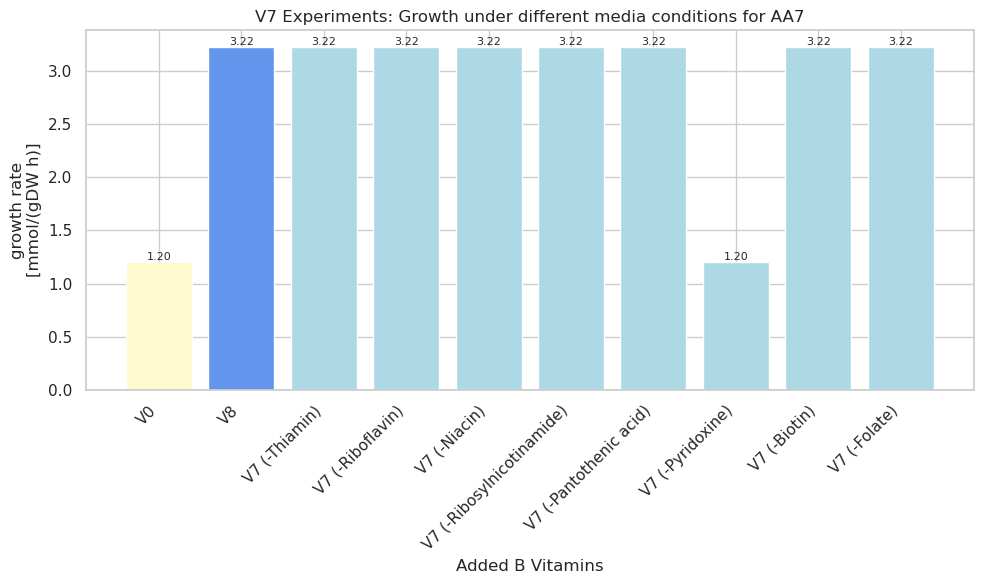

In [29]:
get_v7_growth(AA7, "V7", ala, EX_V8, EX_V8_names)

# AA5 - possible auxotrophies
For Cin (AA5), Krumbach et al. saw no growth during their vitamin in vitro testing. Are we able to find reasons? Not really, because my model is able to grow :c

What is in Krumbach MRE but not in vitamin testing medium?

In [61]:
add_MRE = list(set(medium_combined_krumbach.reaction) - set(medium_for_vitaminTesting.reaction))

In [110]:
medium_combined_krumbach.reaction

0       EX_4abut_e
1      EX_acon_C_e
2      EX_ala__D_e
3      EX_ala__L_e
4       EX_ala_B_e
5      EX_asn__L_e
6      EX_asp__D_e
7      EX_asp__L_e
8         EX_cit_e
9         EX_fru_e
10        EX_fum_e
11    EX_glc__aD_e
12     EX_glc__D_e
13     EX_glu__L_e
14        EX_gly_e
15       EX_icit_e
16     EX_ile__L_e
17      EX_inost_e
18     EX_leu__D_e
19     EX_leu__L_e
20     EX_mal__D_e
21     EX_mal__L_e
22     EX_pro__L_e
23     EX_rib__D_e
24     EX_ser__D_e
25     EX_ser__L_e
26       EX_succ_e
27     EX_thr__L_e
28     EX_val__D_e
29     EX_val__L_e
30     EX_xyl__D_e
31        EX_na1_e
32         EX_pi_e
33        EX_nh4_e
34         EX_cl_e
35          EX_k_e
36          EX_h_e
37        EX_mg2_e
38        EX_so4_e
39        EX_ca2_e
40        EX_fe3_e
41        EX_fe2_e
42        EX_mn2_e
43        EX_zn2_e
44       EX_mobd_e
45         EX_o2_e
46        EX_cu2_e
47    EX_cobalt2_e
Name: reaction, dtype: object

In [62]:
add_MRE

['EX_val__L_e',
 'EX_pro__L_e',
 'EX_asn__L_e',
 'EX_asp__L_e',
 'EX_rib__D_e',
 'EX_ser__L_e',
 'EX_val__D_e',
 'EX_acon_C_e',
 'EX_leu__D_e',
 'EX_ser__D_e',
 'EX_fru_e',
 'EX_thr__L_e',
 'EX_ile__L_e',
 'EX_leu__L_e',
 'EX_fum_e',
 'EX_asp__D_e',
 'EX_icit_e']

In [106]:
for met in add_MRE:
    print(met[3:-1])

val__L_
pro__L_
asn__L_
asp__L_
rib__D_
ser__L_
val__D_
acon_C_
leu__D_
ser__D_
fru_
thr__L_
ile__L_
leu__L_
fum_
asp__D_
icit_


In [112]:
def make_sinks_as_objective(model, medium_dict, met_id):
    rxn_id = "objective_sink_check"
    met_id = met_id[3:-1]+"c" # remove EX_ from beginning to actually make it a met and change _e to _c

    if met_id in model.metabolites:
        met = model.metabolites.get_by_id(met_id)
        stoich = {met: -1}
    else:
        print( f"{met_id} not in {model.id}")
        return

    if rxn_id in model.reactions: # test reaction is updated
        rxn = model.reactions.get_by_id(rxn_id)
        rxn.subtract_metabolites(rxn.metabolites)
        rxn.add_metabolites(stoich)
    else: # first time reaction is created
        new_rxn = Reaction(id=rxn_id, name="objective sink reaction", lower_bound=0, upper_bound=1000)
        new_rxn.add_metabolites(stoich)
        model.add_reactions([new_rxn])

    model.objective = rxn_id

    with model:
        change_medium(model, medium_dict)
        try:
            pfba_flux = pfba(model)
            if pfba_flux[rxn_id] == 0:
                print(f"{met_id} as an objective produces no growth")
                model.objective = "Growth"
                return met_id
            else:
                print(f"{met_id} as an objective produces growth of {pfba_flux[rxn_id]}")
        except Infeasible:
            print("Cannot get result because pfba is infeasible")

    if rxn_id in model.reactions:
        rxn = model.reactions.get_by_id(rxn_id)
        model.remove_reactions([rxn])

    model.objective = "Growth"
    return pfba_flux

In [117]:
for met in medium_combined_krumbach.reaction:
    make_sinks_as_objective(AA5, medium_for_vitaminTesting, met)

4abut_c as an objective produces growth of 94.0
acon_C_c as an objective produces growth of 84.0
ala__D_c as an objective produces growth of 137.39726027397262
ala__L_c as an objective produces growth of 137.3972602739726
ala_B_c as an objective produces growth of 126.66666666666667
asn__L_c as an objective produces growth of 119.75
asp__D_c as an objective produces growth of 126.66666666666667
asp__L_c as an objective produces growth of 126.66666666666667
cit_c as an objective produces growth of 84.0
fru_c not in AA5
fum_c as an objective produces growth of 126.66666666666667
glc__aD_c as an objective produces growth of 62.55952380952381
glc__D_c as an objective produces growth of 62.55952380952381
glu__L_c as an objective produces growth of 84.0
gly_c as an objective produces growth of 255.0
icit_c as an objective produces growth of 84.0
ile__L_c as an objective produces growth of 54.578313253012055
inost_c as an objective produces growth of 10.0
leu__D_c not in AA5
leu__L_c as an ob

In [108]:
for met in add_MRE:
    make_sinks_as_objective(AA5, medium_for_vitaminTesting, met)

val__L_c as an objective produces growth
pro__L_c as an objective produces growth
asn__L_c as an objective produces growth
asp__L_c as an objective produces growth
rib__D_c as an objective produces no growth
ser__L_c as an objective produces growth
val__D_c not in AA5
acon_C_c as an objective produces growth
leu__D_c not in AA5
ser__D_c as an objective produces growth
fru_c not in AA5
thr__L_c as an objective produces growth
ile__L_c as an objective produces growth
leu__L_c as an objective produces growth
fum_c as an objective produces growth
asp__D_c as an objective produces growth
icit_c as an objective produces growth


lets look at the fluxes of AA5 when provided with the vitamin medium (carbon sources, M9 and vitamins)

In [77]:
new_df = pd.DataFrame({
    "reaction": EX_V8,
    "bound": 10
})
vitamin_testing_extended = pd.concat([medium_for_vitaminTesting, new_df], ignore_index=True)

In [103]:
aa5_flux = get_pfba_fluxes(AA5, vitamin_testing_extended)
aa5_flux = pd.DataFrame(aa5_flux)

In [105]:
AA5.reactions.Growth.metabolites

{<Metabolite 10fthf_c at 0x7611e1afbfd0>: -0.000223,
 <Metabolite ala__L_c at 0x7611e2dfc610>: -0.513689,
 <Metabolite amet_c at 0x7611e2dfc9d0>: -0.000223,
 <Metabolite arg__L_c at 0x7611e2dfcf70>: -0.295792,
 <Metabolite asn__L_c at 0x7611e2dfd060>: -0.241055,
 <Metabolite asp__L_c at 0x7611e2dfd240>: -0.241055,
 <Metabolite atp_c at 0x7611e2dfd330>: -54.124831,
 <Metabolite ca2_c at 0x7611e2dfd6f0>: -0.005205,
 <Metabolite cl_c at 0x7611e2dfe050>: -0.005205,
 <Metabolite coa_c at 0x7611e2dfe440>: -0.000576,
 <Metabolite cobalt2_c at 0x7611e2dfe470>: -0.0001,
 <Metabolite ctp_c at 0x7611e2dfe6e0>: -0.133508,
 <Metabolite cu2_c at 0x7611e2dfe710>: -0.000709,
 <Metabolite cys__L_c at 0x7611e2dfe860>: -0.09158,
 <Metabolite datp_c at 0x7611e2dfead0>: -0.026166,
 <Metabolite dctp_c at 0x7611e2dfec80>: -0.027017,
 <Metabolite dgtp_c at 0x7611e2dfef80>: -0.027017,
 <Metabolite dttp_c at 0x7611e2dff670>: -0.026166,
 <Metabolite fad_c at 0x7611e2dffac0>: -0.000223,
 <Metabolite fe2_c at 0x76

In [104]:
aa5_flux[aa5_flux["fluxes"] < 0 & aa5_flux.index.str.startswith("EX_")]

,fluxes
EX_akg_e,-10.000000
EX_ala__L_e,-10.000000
EX_arg__L_e,-10.000000
EX_ca2_e,-0.044622
EX_cit_e,-10.000000
...,...
TKT2,-1.615363
TRPAS2,-0.487310
TYRTA,-1.182170
r2465_1,-0.002923


# Adding all EX reactions for vitamins (without any other gap-filling)

I am adding EX reactions if the vitamin is at least present in the cytosol; if we're missing the met in _e, then it gets added toegther with a basic transporter from _c to _e and the EX reaction

In [31]:
def add_vitamin_exchanges(model, cytosolic_ids):
    """
    For each metabolite in cytosolic_ids:
      - if it exists in the model as _c
      - ensure an extracellular _e metabolite
      - add a transport c <-> e
      - add an exchange EX_met_e
    """
    for met_id_c in cytosolic_ids:
        if met_id_c not in model.metabolites:
            continue  # skip if cytosolic metabolite not present

        met_c = model.metabolites.get_by_id(met_id_c)
        met_id_e = met_id_c[:-2] + "_e"

        # check or create extracellular metabolite
        if met_id_e in model.metabolites:
            met_e = model.metabolites.get_by_id(met_id_e)
        else:
            met_e = Metabolite(
                met_id_e,
                name=met_c.name + " (extracellular)",
                formula=met_c.formula,
                charge=met_c.charge,
                compartment="C_e"
            )
            model.add_metabolites([met_e])

        # add transport if missing
        t_id = f"T_{met_c.id[:-2]}"
        if t_id not in model.reactions:
            rxn_t = Reaction(t_id)
            rxn_t.name = f"Transport {met_c.name} c<->e"
            rxn_t.add_metabolites({met_c: -1.0, met_e: 1.0})
            rxn_t.lower_bound = -1000.0
            rxn_t.upper_bound = 1000.0
            model.add_reactions([rxn_t])

        # add exchange if missing
        ex_id = f"EX_{met_e.id}"
        if ex_id not in model.reactions:
            rxn_ex = Reaction(ex_id)
            rxn_ex.name = f"Exchange {met_e.name}"
            rxn_ex.add_metabolites({met_e: -1.0})
            rxn_ex.lower_bound = -1000.0
            rxn_ex.upper_bound = 1000.0
            model.add_reactions([rxn_ex])


In [35]:
vitamin_ids = [
    "thm_c",     # B1
    "ribflv_c",  # B2
    "nac_c",     # B3
    "ncam_c",    # B3
    "pnto__R_c",  # B5
    "pydxn_c",   # B6
    "btn_c",     # B7
    "fol_c",     # B9
    "adocbi_c"     # B12
]


In [32]:
extended_vitamin_ids = [
    "thm_c",     # B1
    "thmmp_c",   # B1
    "thmpp_c",   # B1
    "ribflv_c",  # B2
    "nac_c",     # B3
    "ncam_c",    # B3
    "rnam_c"     # B3
    "pnto__R_c",  # B5
    "pydxn_c",  # B6
    "pydam_c"   # B6
    "pydx_c",   # B6
    "btn_c",    # B7
    "fol_c",    # B9
    "5mthf_c",  # B9
    "adocbi_c"  # B12
]

In [36]:
for model in models_vit.values():
    add_vitamin_exchanges(model, vitamin_ids)
# i also tried the extended list of vitamins to include even more EX reactions but the growth values didnt change

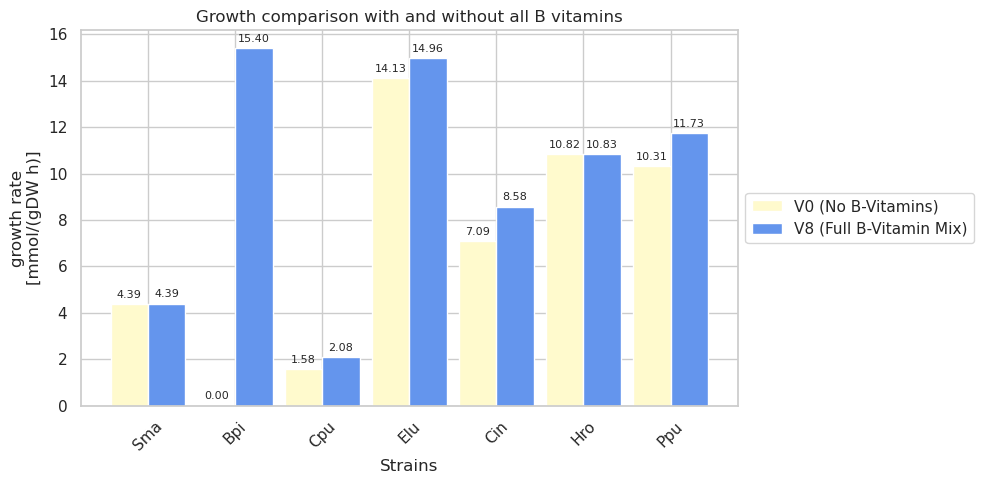

In [37]:
vitamin_growth_plots(models_vit, medium_for_vitaminTesting, EX_V8)

Bpi boosted its growth a bit more (~0.8); for Elu it is the first time we see a growth boost.
Cin and Ppu only + 0.01. \
Sma doesnt care, Cpu & Hro also no differences \
AA1 (Sma) doesnt have some of the vitamins in _c

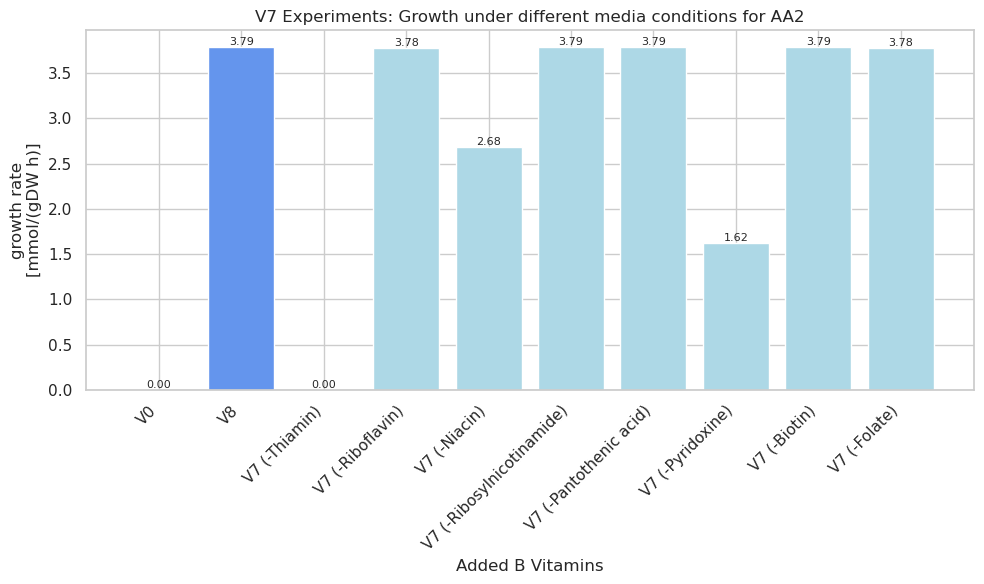

In [38]:
get_v7_growth(AA2_v, "V7", ala, EX_V8, EX_V8_names)

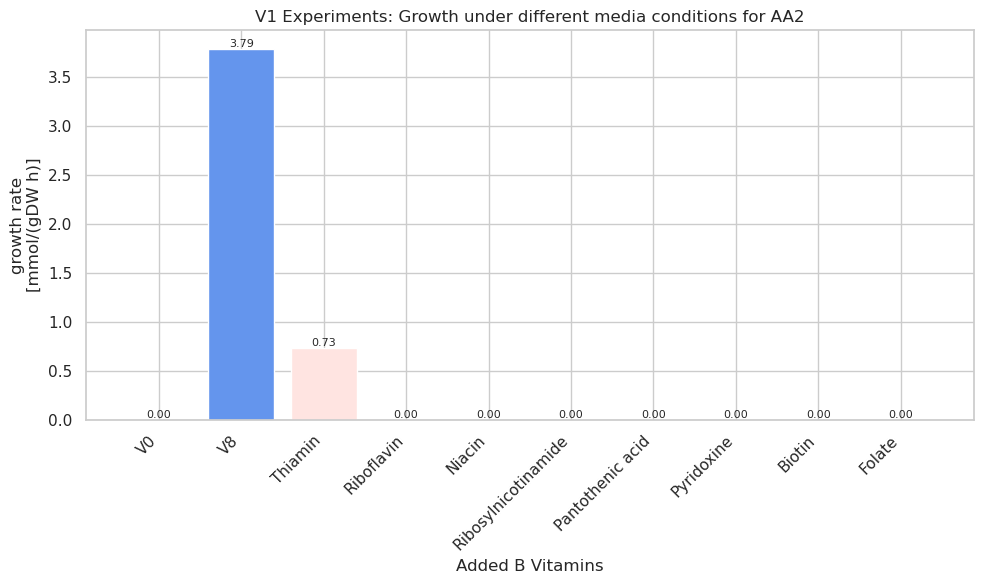

In [39]:
get_v1_growth(AA2_v, "V1", ala, EX_V8, EX_V8_names)

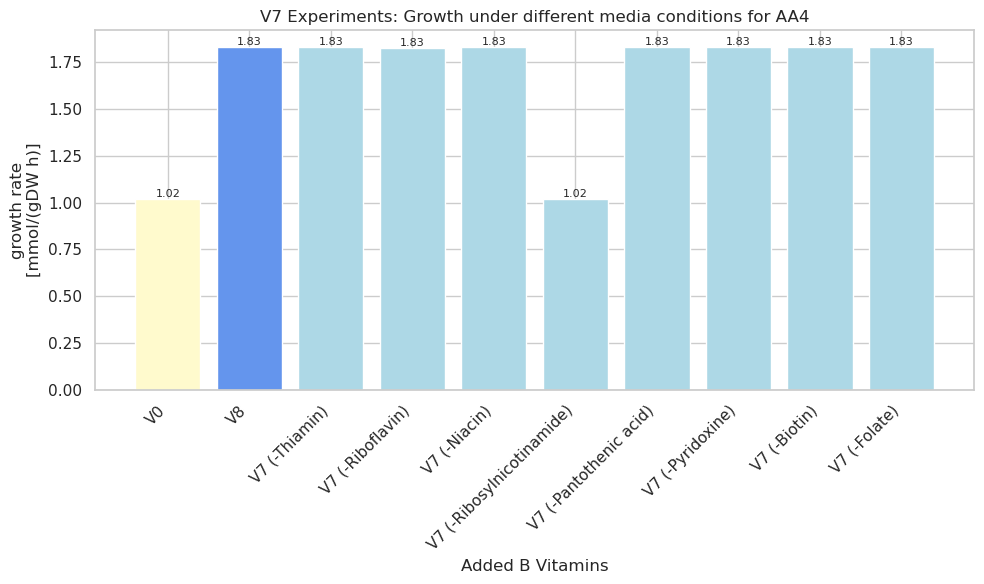

In [40]:
get_v7_growth(AA4_v, "V7", glu, EX_V8, EX_V8_names)

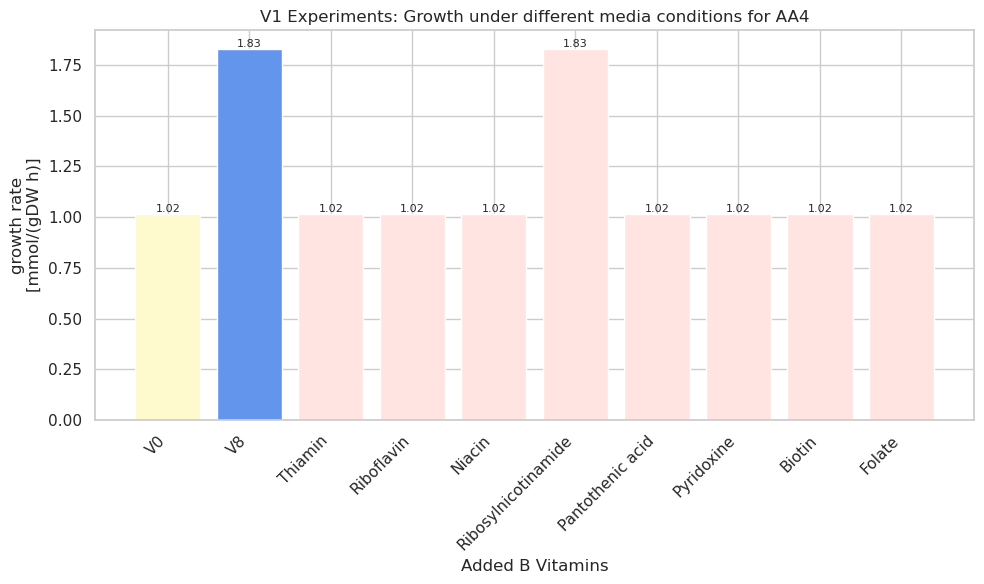

In [41]:
get_v1_growth(AA4_v, "V1", glu, EX_V8, EX_V8_names)

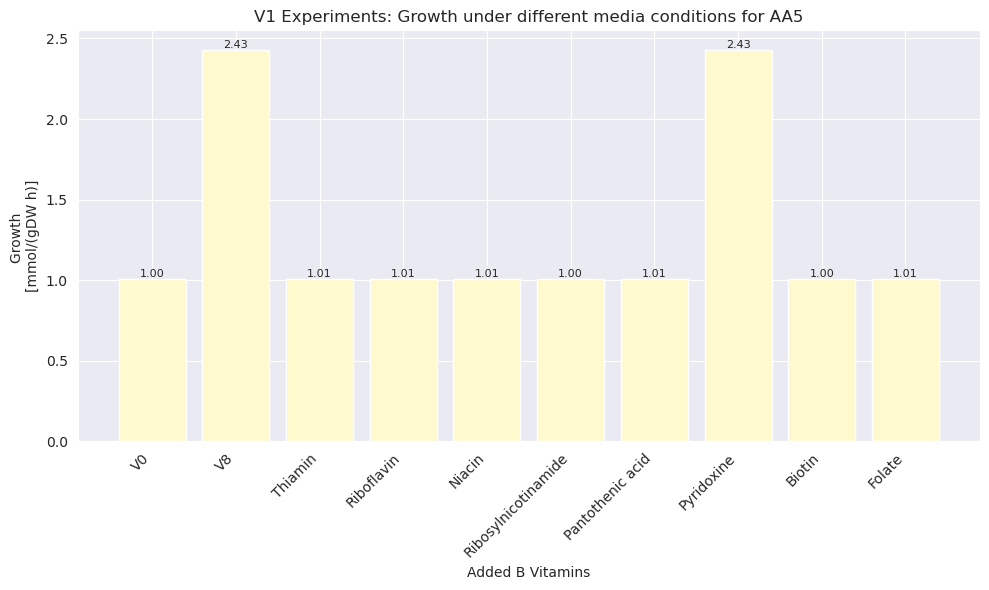

In [142]:
get_v1_growth(AA5_v, "V1", glu, EX_V8, EX_V8_names)

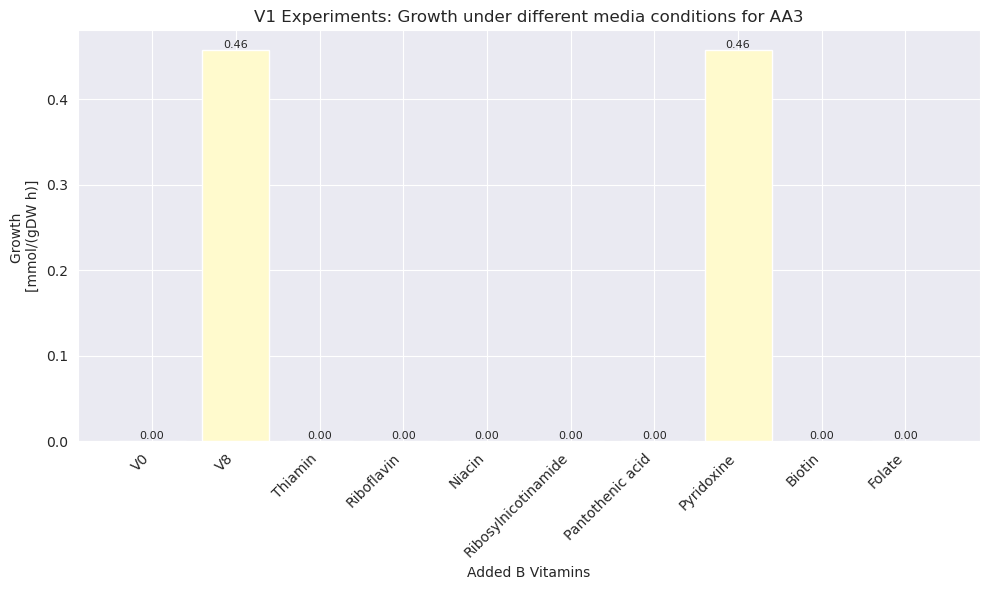

In [146]:
get_v1_growth(AA3, "V1", ala, EX_V8, EX_V8_names) # AA3 uses the vitamin basically just as a carbon source

# Bpi & Cpu
according to Krumbach those two can have auxotrophies for \
Bpi - thiamine & biotin \
Cpu - all B vitamins expect B12 (cobalamin)

Therefore, these vitamins were added to the biomass in step (6) add auxotrophies based on Krumbach

in AA2 in the 13_vitamins model folder, AA2 already has the biotin synthese pathway gapfilled; just block "PIMACPS" as a reaction to disable to synthesis pathway

In [17]:
test_medium(AA2, medium_combined_krumbach)

0.0

In [26]:
test_medium(AA2_btn, medium_combined_krumbach) # no thm, so 0 growth for sure

0.0

In [25]:
test_medium(AA2_btn, medium_combined_krumbach_thm)

15.401250404485058

In [24]:
get_rxn(AA2_btn, "PIMACPS")

PIMACPS: epACP_c + h_c + nadh_c --> nad_c + pimACP_c


In [28]:
with AA2_btn:
    AA2_btn.reactions.get_by_id("PIMACPS").knock_out()
    print(test_medium(AA2, medium_combined_krumbach_thm))

15.40317291996237


In [6]:
test_medium(AA3_btn_pan, medium_combined_krumbach)

0.0

In [32]:
check_early_biomass_component(AA3_btn_pan, medium_combined_krumbach, "Growth")

['btn_c']


In [7]:
new_row = {"reaction": "EX_btn_e", "bound": 10.0}
medium_combined_krumbach_btn = pd.concat([medium_combined_krumbach, pd.DataFrame([new_row])], ignore_index=True)

In [23]:
new_row = {"reaction": ["EX_pnto__R_e", "EX_btn_e"], "bound": [10.0, 10.0]}
medium_combined_krumbach_btn_pan = pd.concat([medium_combined_krumbach, pd.DataFrame(new_row)], ignore_index=True)

In [42]:
test_medium(AA3, medium_combined_krumbach)

1.9584272055034488

In [8]:
test_medium(AA3_btn_pan, medium_combined_krumbach_btn)

1.9583918784296772

In [24]:
test_medium(AA3_btn_pan, medium_combined_krumbach_btn_pan)

1.9583918784296808

In [25]:
print(test_medium(AA3_btn_pan, medium_combined_krumbach))

0.0
